In [2]:
import torch 
from torchvision.models import resnet50,ResNet50_Weights,resnet152,ResNet152_Weights
import torchvision
import os
os.environ['TORCH_HOME']=r"D:\torch_model"

In [3]:
weights = torchvision.models.ResNet152_Weights.IMAGENET1K_V1
net = torchvision.models.resnet152(weights=weights)

In [6]:
from d2l import torch as d2l
from torch.utils.data import DataLoader,Dataset,Subset
import numpy as np
from PIL import Image


class AddSaltPepperNoise(object):
    def __init__(self, density=0):
        self.density = density
    def __call__(self, img):
        img = np.array(img)                                                             # 图片转numpy
        h, w, c = img.shape
        Nd = self.density
        Sd = 1 - Nd
        mask = np.random.choice((0, 1, 2), size=(h, w, 1), p=[Nd/2.0, Nd/2.0, Sd])      # 生成一个通道的mask
        mask = np.repeat(mask, c, axis=2)                                               # 在通道的维度复制，生成彩色的mask
        img[mask == 0] = 0                                                              # 椒
        img[mask == 1] = 255                                                            # 盐
        img= Image.fromarray(img.astype('uint8')).convert('RGB')                        # numpy转图片
        return img
train_transforms = torchvision.transforms.Compose([
    AddSaltPepperNoise(0.2),
    torchvision.transforms.transforms.RandomRotation(10),  # 随机旋转

    torchvision.transforms.transforms.ColorJitter(0.4, 0.4, 0.4, 0.2),  # 随机颜色抖动
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5]),
])
dataset=torchvision.datasets.ImageFolder(root=r'D:\project_meta\NNproject\NNI\output\video_frames\LEVEL',transform=train_transforms)

from sklearn.model_selection import train_test_split
import datetime

train_dataset=torchvision.datasets.ImageFolder(root=r'D:\project_meta\NNproject\NNI\output\video_frames\IDSplite\train',transform=train_transforms)
train_dataloader=DataLoader(train_dataset,batch_size=64,shuffle=True)

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5]),
])
test_dataset=torchvision.datasets.ImageFolder(root=r'D:\project_meta\NNproject\NNI\output\video_frames\IDSplite\test',transform=test_transforms)

test_dataloader=DataLoader(test_dataset,batch_size=128,shuffle=True)
# test_dataset=torchvision.datasets.ImageFolder(root=r'D:\project_meta\NNproject\NNI\output\video_frames\IDSplit\test',transform=transforms)

timer, num_batches = d2l.Timer(), len(train_dataloader)
 
print(num_batches)

48


In [5]:
# from sklearn.model_selection import train_test_split
# import datetime
# indexs=torch.tensor(range(len(dataset)))
# train_dataset_index,test_dataset_index=train_test_split(indexs,test_size=0.3,shuffle=False)
# train_dataset=Subset(dataset=dataset,indices=train_dataset_index)
# test_dataset=Subset(dataset=dataset,indices=test_dataset_index)
# train_dataloader=DataLoader(train_dataset,batch_size=64,shuffle=True)
# test_dataloader=DataLoader(test_dataset,batch_size=128,shuffle=True)

# timer, num_batches = d2l.Timer(), len(train_dataloader)
 
# print(num_batches)


In [15]:
optim=torch.optim.SGD(net.parameters(),lr=1,weight_decay=5e-4)
lr_sch=torch.optim.lr_scheduler.MultiStepLR(optim,[3,7,9],0.7)
for i in range(15):
    print(optim.state_dict()['param_groups'][0]['lr'])
    lr_sch.step()
   

1
1
1
0.7
0.7
0.7
0.7
0.48999999999999994
0.48999999999999994
0.3429999999999999
0.3429999999999999
0.3429999999999999
0.3429999999999999
0.3429999999999999
0.3429999999999999


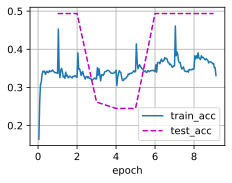

In [21]:
import torch.nn.functional as F
import torch
device=torch.device('cuda')
net=resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
optim=torch.optim.Adam(net.parameters(),lr=1,weight_decay=5e-4)

lr_sch=torch.optim.lr_scheduler.MultiStepLR(optim,[1,2,3,4,5,6,7,8,9],0.97)
loss=torch.nn.CrossEntropyLoss().to(device="cuda")
num_epochs=15
best_train_acc=0
best_train_loss=0
best_test_acc=0
stagnate_times=0
temp_acc=0

train_acc_list=[]
test_acc_list=[]
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y_%m_%d_%H_%M_%S")
parameterFolder=os.path.join(r"D:\project_meta\NNproject\NNI\output\model_parameter\FaceDetect",f"{formatted_time}")

print(parameterFolder)
os.makedirs(parameterFolder)
animator = d2l.Animator(xlabel='epoch',
                        legend=['train_acc','test_acc'])  
for epoch in range(num_epochs):
    metric_train = d2l.Accumulator(2)
    net.train()
    for i,data_dict in enumerate(train_dataloader):
        optim.zero_grad()
        x=data_dict[0].to(device)
        x=x+torch.randn_like(x).to(device) /100   
        y=data_dict[1].long().to(device)
        y_hat=net(x)
        l=F.cross_entropy(y_hat, y)
        l.mean().backward()
        optim.step()     
        pre=torch.argmax(y_hat.detach().cpu(),dim=1)
        num_true=sum(pre==y.cpu())
        metric_train.add(num_true,y.numel())
        
        if (i + 1) % (num_batches // 20) == 0 or i == num_batches - 1:
            animator.add(epoch + (i + 1) / num_batches, (metric_train[0]/metric_train[1],None))
            train_acc_list.append(metric_train[0]/metric_train[1])

    lr_sch.step()    
    
    net.eval()
    with torch.no_grad():
        metric_test = d2l.Accumulator(2)
        for data_dict in test_dataloader:
            x=data_dict[0].to(torch.float32).to(device)
            y=data_dict[1].long().to(device)
            y_hat=net(x)
            pre=torch.argmax(y_hat.detach().cpu(),dim=1)
            num_true=sum(pre==y.cpu())
            metric_test.add(num_true,y.numel())
        animator.add(epoch+ 1, (None,metric_test[0]/metric_test[1]))
        test_acc_list.append(metric_test[0]/metric_test[1])
        if best_test_acc<(metric_test[0]/metric_test[1]):
            best_test_acc=metric_test[0]/metric_test[1]

            
            
            torch.save(net.state_dict(),os.path.join(parameterFolder,f'{best_test_acc}.pt'))
        else:
            stagnate_times=stagnate_times+1
        
        if stagnate_times>50:
            break

animator.fig.fig.savefig(os.path.join(parameterFolder,'my_plot.png'))

In [20]:

animator.fig.savefig(os.path.join(parameterFolder,'my_plot.png'))

# K折交叉

In [19]:
dataset=torchvision.datasets.ImageFolder(root=r'D:\project_meta\NNproject\NNI\output\video_frames\LEVEL')
timer, num_batches = d2l.Timer(), len(train_dataloader)

D:\project_meta\NNproject\NNI\output\model_parameter\FaceClassfier\2023_11_16_08_55_57


KeyboardInterrupt: 

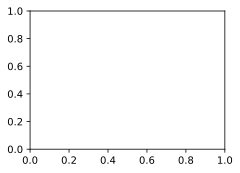

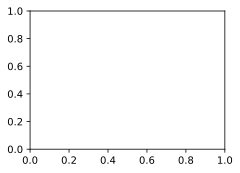

In [18]:
from sklearn.model_selection import train_test_split
import datetime
#设定权重保存目录
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y_%m_%d_%H_%M_%S")
parameterFolder=os.path.join(r"D:\project_meta\NNproject\NNI\output\model_parameter\FaceClassfier",f"{formatted_time}")
print(parameterFolder)
os.makedirs(parameterFolder)

dataset=torchvision.datasets.ImageFolder(root=r'D:\project_meta\NNproject\NNI\output\video_frames\LEVEL',transform=transforms)
timer, num_batches = d2l.Timer(), len(train_dataloader)

from sklearn.model_selection import KFold
 
kf = KFold(n_splits=7, shuffle=False)
AnimatorList=[]
for  kf_i,(train_index, val_index) in enumerate(kf.split(dataset)):
    # print(train_index, test_index)
    AnimatorList.append( d2l.Animator(xlabel='epoch',
                        legend=['train_acc','test_acc']))
    animator=AnimatorList[kf_i]
    train_fold = torch.utils.data.dataset.Subset(dataset, train_index)
    val_fold = torch.utils.data.dataset.Subset(dataset, val_index)   
    device=torch.device('cuda')
    net=resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
    optim=torch.optim.SGD(net.parameters(),lr=0.05,weight_decay=5e-4)
    lr_sch=torch.optim.lr_scheduler.MultiStepLR(optim,[3,7,11],0.7)
    loss=torch.nn.CrossEntropyLoss().to(device="cuda")
    num_epochs=50
    best_train_acc=0
    best_train_loss=0
    best_test_acc=0
    stagnate_times=0
    temp_acc=0

    animator = d2l.Animator(xlabel='epoch',
                            legend=['train_acc','test_acc'])  
    for epoch in range(num_epochs):
        metric_train = d2l.Accumulator(2)
        net.train()
        for i,data_dict in enumerate(train_dataloader):
            optim.zero_grad()
            x=data_dict[0].to(device)
            x=x+torch.randn_like(x).to(device) /100   
            y=data_dict[1].long().to(device)
            y_hat=net(x)
            l=F.cross_entropy(y_hat, y)
            l.mean().backward()
            optim.step()     
            pre=torch.argmax(y_hat.detach().cpu(),dim=1)
            num_true=sum(pre==y.cpu())
            metric_train.add(num_true,y.numel())
            
            if (i + 1) % (num_batches // 1) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric_train[0]/metric_train[1],None))
            
        lr_sch.step()
        net.eval()
        with torch.no_grad():
            metric_test = d2l.Accumulator(2)
            for data_dict in test_dataloader:
                x=data_dict[0].to(torch.float32).to(device)
                y=data_dict[1].long().to(device)
                y_hat=net(x)
                pre=torch.argmax(y_hat.detach().cpu(),dim=1)
                num_true=sum(pre==y.cpu())
                metric_test.add(num_true,y.numel())
            animator.add(epoch+ 1, (None,metric_test[0]/metric_test[1]))

            if best_test_acc<(metric_test[0]/metric_test[1]):
                best_test_acc=metric_test[0]/metric_test[1]
                stagnate_times=0
                
                
                torch.save(net.state_dict(),os.path.join(parameterFolder,f'{kf_i}{best_test_acc}.pt'))
            else:
                stagnate_times=stagnate_times+1
            
            if stagnate_times>50:
                break 
    

In [ ]:
torch.cuda.empty_cache()

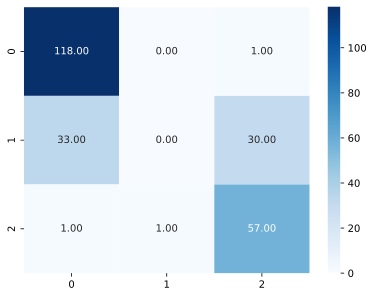

In [9]:

from sklearn.metrics import confusion_matrix
import numpy as np
import torch
test_dataset=torchvision.datasets.ImageFolder(root=r'D:\project_meta\NNproject\NNI\output\video_frames\IDFolder\test',transform=transforms)
test_dataloader=DataLoader(test_dataset,batch_size=128,shuffle=True)
timer, num_batches = d2l.Timer(), len(train_dataloader)
torch.cuda.empty_cache()
device=torch.device('cuda')
net=resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
net.eval()
with torch.no_grad():
    num_classes=3
    test_dataloader=DataLoader(test_dataset,batch_size=128)
    confusion_matrix_test = np.zeros((num_classes, num_classes))
    net.load_state_dict(torch.load(r"D:\project_meta\NNproject\NNI\output\model_parameter\FaceDetect\2023_11_14_13_09_20\0.7261410788381742.pt"))
    for data_dict in test_dataloader:
        x=data_dict[0].to(torch.float32).to(device)
        y=data_dict[1].long().to(device)
        y_hat=net(x)
        pre=torch.argmax(y_hat.detach().cpu(),dim=1)
        num_true=sum(pre==y.cpu())
        y_pred = torch.stack((pre, y.cpu()), dim=1)
        confusion_matrix_test += confusion_matrix(y_pred[:, 1], y_pred[:, 0], labels=range(num_classes))
    import seaborn as sns
    sns.heatmap(confusion_matrix_test,annot=True, fmt=".2f", cmap="Blues")